In [2]:
import bs4
import requests
import numpy as np
import re
import string
import pandas as pd
import time
import google.generativeai as genai
from google.api_core.exceptions import ResourceExhausted
import matplotlib.pyplot as plt

c:\Users\shach\.conda\envs\oded2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# import players names
male_names = np.genfromtxt(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\raw files\players\atp_players.csv",
                            delimiter=',', dtype=str, skip_header=1)
female_names = np.genfromtxt(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\raw files\players\wta_players.csv",
                            delimiter=',', dtype=str, skip_header=1)

# concatenate the names
# for each file, the names are the second and third columns
# create a list of names in the format of "first_name, last_name"
def concate_second_and_third(arr):
    return arr[2] + ", " + arr[1]
list_of_names = list(map(concate_second_and_third, male_names)) + list(map(concate_second_and_third, female_names))

In [6]:
# for each letter in the alphabet, get the names of players
# for each name, get the link to the player's page
URL_temp = r'https://www.asapsports.com/show_player.php?category=7&letter='
people = {}
for letter in string.ascii_lowercase:
    URL = URL_temp + letter
    r = requests.get(URL)

    # the page containe names of people
    # list all the names
    # for each name, get the link
    soup = bs4.BeautifulSoup(r.content, 'html5lib')
    for a in soup.find_all('a', href=True):
        name = a.text
        if name in list_of_names:
            people[name] = {
                'link': a['href'],
                'content': []
            }

In [ ]:
# return the index of the first cell that contains with "FastScripts"
# the interview always ends with a sentence that has "FastScripts"
def index_of_fastscripts_cell(arr):
    for i in range(len(arr),0,-1):
        if "FastScripts" in arr[i-1]:
            return i-1
    return len(arr)

# get the index and name of the last player we got his interviews
def get_last_player_index(people):
    index = 0
    result_name = ""
    for i, name in enumerate(people):
        if people[name]['content'] != []:
            index = i
            result_name = name
    return [index, result_name]

get_last_player_index(people)[1]

In [ ]:
# for each player, get the content of the interviews
# start where we stopped last time
index_of_last_player = get_last_player_index(people)[0]
name_of_last_player = get_last_player_index(people)[1]
if name_of_last_player != "":
    people[name_of_last_player]["content"] = [] # reset the content of the last player
for name in dict(list(people.items())[index_of_last_player:]):
    link = people[name]['link']
    URL = link
    r = requests.get(URL)
    soup = bs4.BeautifulSoup(r.content, 'html5lib')
    # if the player has too little interviews (less than 4), skip
    if (len(soup.find_all('a', href=True)) < 35):
        continue
    print(name)
    interview_count = 0  # Initialize interview count for the player
    for a in reversed(soup.find_all('a', href=True)): # Reverse the order of links to collect the first interviews
        if interview_count >= 50:
            print("BREAK")
            break # Stop scraping if we have already collected 50 interviews
        # making sure we are getting interview from a tournment (not just press conference\ announcement)
        if 'show_interview.php' in a['href'] and ['ANNOUNCEMENT', 'CONFERENCE'] not in a.contents:
            # if we got to here, we have a link to a page with the content
            # now we need to get the content
            URL = a['href']
            r = requests.get(URL)
            soup = bs4.BeautifulSoup(r.content, 'html5lib')
            p = soup.find_all('td')[13] # the actuall content
            if (len([h3 for h3 in p.find_all('h3') if h3.find('a', href=True)]) > 1) or "CAPTAIN" in p.text[501:]:
                # skip if more than one intervieiw in the page
                # (most international games that have more than one interview contain the word "CAPTAIN" in the content)
                continue 
            # get the content without the generics
            text_arr = p.text[501:].split("\n")
            text_arr = list(filter(lambda x: x not in ['\t\t  ']
                                    and x != "",
                                    text_arr))
            people[name]['content'].append(text_arr[:index_of_fastscripts_cell(text_arr)])
            interview_count += 1

In [3]:
interview_data = pd.read_csv(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\python\processed_interviews.csv")
interview_data["date"] = pd.to_datetime(interview_data["date"], errors='coerce')
interview_data["content"] = interview_data["content"].apply(lambda x: eval(x))

interview_data[interview_data["won"]==999]

,name,cup,date,won,interview,content
16,"Agassi, Andre",THE LIPTON CHAMPIONSHIPS,1994-03-17,999.0,"Q. Andre, that must be a very satisfying resu...","[THE LIPTON CHAMPIONSHIPS, \t\t March 17, 199..."
101,"Alcaraz, Carlos",THE CHAMPIONSHIPS,2022-06-26,999.0,"THE MODERATOR: Carlos, how have your preparati...","[THE CHAMPIONSHIPS, \t\t June 26, 2022, \t\t ..."
108,"Alcaraz, Carlos",US OPEN,2022-08-26,999.0,"THE MODERATOR: Carlos, your thoughts on the US...","[US OPEN, \t\t August 26, 2022, \t\t Carlos ..."
118,"Almagro, Nicolas",AUSTRALIAN OPEN,2013-01-18,999.0,"THE MODERATOR:Â Questions, please. Q.Â The Lan...","[AUSTRALIAN OPEN, \t\t January 18, 2013, \t\t..."
214,"Andreescu, Bianca",CHINA OPEN,2019-09-27,999.0,"THE MODERATOR: Questions, please. Q. Your impr...","[CHINA OPEN, \t\t September 27, 2019, \t\t B..."
...,...,...,...,...,...,...
13617,"Zverev, Alexander",SHANGHAI ROLEX MASTERS,2017-10-09,999.0,"THE MODERATOR: Questions in English, please. Q...","[SHANGHAI ROLEX MASTERS, \t\t October 9, 2017..."
13622,"Zverev, Alexander",AUSTRALIAN OPEN,2018-01-13,999.0,"THE MODERATOR: Questions, please. Q. How are y...","[AUSTRALIAN OPEN, \t\t January 13, 2018, \t\t..."
13648,"Zvonareva, Vera",US OPEN,2002-08-31,999.0,"THE MODERATOR: First question, please. Q. Whe...","[US OPEN, \t\t August 31, 2002, \t\t Vera Zv..."
13679,"Zvonareva, Vera",WIMBLEDON,2010-07-02,999.0,"THE MODERATOR: Questions, please. Q. Is fitne...","[WIMBLEDON, \t\t July 2, 2010, \t\t Vera Zvo..."


In [ ]:
# returning the name in the format of the interviews
def get_caped_name(name):
    caped_name = name.split(", ")
    caped_name = " ".join([caped_name[1], caped_name[0]])
    return caped_name.upper()

# replacing the name in the interview with "SPEAKER"
def replace_name_in_interviews(name, interview):
    return interview.replace(get_caped_name(name), "SPEAKER")

# asking gemini to tell if the speaker won or lost
def ask_gemini(content, name):
    promt = "I need your help in determining the outcome of a tennis match. I will provide you with a post-game interview of a tennis player. Return 1 if you think the SPEAKER won, and 0 if he\ she lost. If you are not sure return 9. Your final answer should be only a number. Here is the interview: \n"
    #GOOGLE_API_KEY = "your API key goes here" 
    genai.configure(api_key=GOOGLE_API_KEY)
    #model = genai.GenerativeModel('gemini-1.5-flash')
    #model = genai.GenerativeModel('gemini-1.0-pro')
    model = genai.GenerativeModel('gemini-1.5-pro')
    interview = re.sub(r'\s+', ' ', "\n".join(content))
    interview = replace_name_in_interviews(name, interview)
    for j in range(3):
        try:
            response = model.generate_content(promt + interview)
            if response.text.strip() == "1":
                return 1
            elif response.text.strip() == "0":
                return 0
            elif response.text.strip() == "9":
                print("COULDN'T DETERMINE ", interview)
                return 999
        except ResourceExhausted:
                print("ResourceExhausted error, retrying in 1 minute...")
                time.sleep(61)  # Wait for 1 minute before retrying
        
        except Exception:
            print("Exception!!! ", interview)
            return 999
    print("NOTHING WORKED! ", interview)
    return None

In [7]:
# get the index that starts the interview
def get_index_of_interview(arr, name):
    players_that_start_with_q = ["Q. Halys", "Q. Wang", "Q. Vega", "Q. Lemoine", "Q. HALYS", "Q. WANG", "Q. VEGA", "Q. LEMOINE"]
    pattern = re.compile(r"(MODERATOR|Q\.)")
    for i, element in enumerate(arr):
        if pattern.search(element):  # Check if element contains "MODERATOR" or "Q."
            bool = True # assume the "Q. " is true
            if any(map(lambda player: player in element, players_that_start_with_q)):  # checks if the "Q. " is true because of a player's name
                bool = False
            if bool:
                return i
    # if we got here, we missed the start of the interview
    # we will try to find the first time the player's name is all capps
    # and return one line before that
    split_name = name.split(", ")
    if "-" in split_name[0]: # if there are two last names
        split_name[0] = split_name[0].split("-")[0] # take the first last name
    name = split_name[1].upper() +" "+ split_name[0].upper()
    for i, element in enumerate(arr):
        if name in element:
            return i-1
    return 0

# get the whole content of the interview and check if won
# we do this manually trying to find the score
# most of the times (2006 and earlier) the score is not in the interview so we will ask Gemini for help
# won = True, lost = False, don't know = None
def check_if_won(content, name):
    split_name = name.split(", ")
    winner_name = split_name[1][0].upper() + ". " + split_name[0].upper() # winner name is in the format "F. ABANDA"
    print(winner_name)
    loser_name = split_name[1][0].upper() + ". " + split_name[0] # loser name is in the format "F. Abanda"
    print(loser_name)
    i = 999 # position of the winner name in the sentence
    for j, sentence in enumerate(content):
        if loser_name in sentence:
            return 0
        if winner_name in sentence:
            print(sentence)
            clean_sentence = re.sub(r'^[^A-Z]*', '', sentence)
            split_sentence = clean_sentence.split("/")
            split_sentence = [s.strip() for s in split_sentence]
            try:
                i = split_sentence.index(winner_name)
                if not split_sentence[1-i].isupper():
                    return 1
            except ValueError:
                print(split_sentence)
                pass
        # if the sentence doesn't contain any letters and contains digits and "-" it is probably a score
        # we check also that we got the position of the player's name in the previous sentence
        if not re.search(r'[a-zA-Z]', sentence) and re.search(r'[0-9]', sentence) and "-" in sentence and i in [0,1]:
            scores = sentence.split(", ")
            num_of_wins = 0
            for score in scores:
                split_score = score.split("-")
                if int(split_score[i]) > int(split_score[1-i]):
                    num_of_wins += 1
            if num_of_wins > len(scores)/2: #won
                return 1
            else: #lost
                return 0
        if "MODERATOR" in sentence or j >20: # the interview already started
            break
    # if we got here, we didn't find the score
    # we will ask Gemini for help later
    return None

# get array and returns the interview transcript
def return_interview_transcript(content, index):
    text = "\n".join(content[index:])
    text = text.strip()
    return re.sub(r'\s+', ' ', text)

# turn content to an array
# columns will be: name, cup, date, and a text with the whole interview
def content_to_array(content, name):
    index = get_index_of_interview(content, name)
    return {"name":name, "cup":content[0], "date":content[1][4:], "won":check_if_won(content, name),
             "interview":return_interview_transcript(content, index), "content":content}

In [ ]:
interview_data = pd.DataFrame(columns=['name', 'cup', 'date', 'won', 'interview', 'content'])
for name in people:
    for content in people[name]['content']:
        interview_data = pd.concat([interview_data, pd.DataFrame([content_to_array(content, name)])], ignore_index=True)
interview_data

In [10]:
# filling the missing values in the "won" column with the help of Gemini
from tqdm import tqdm
filled = 0
not_filled = 0
last_print = filled + not_filled
for i in tqdm(range(len(interview_data)), desc="Processing interviews"):
    if (filled + not_filled) % 10 == 0 and filled + not_filled != last_print: 
        print("filled: ", filled, "not_filled: ", not_filled)
        last_print = filled + not_filled
    if pd.isna(interview_data["won"][i]) or interview_data["won"][i] == 999:
        response = ask_gemini(interview_data["content"][i], interview_data["name"][i])
        if response == None:
            break
        if response == 999:
            not_filled += 1
        else:
            filled += 1
        interview_data.at[i,"won"] = response

Processing interviews:   0%|          | 17/13698 [00:01<22:34, 10.10it/s]

Exception!!!  THE LIPTON CHAMPIONSHIPS March 17, 1994 Andre Agassi KEY BISCAYNE, FLORIDA Q. Andre, that must be a very satisfying result. SPEAKER: To say the least, you know. More sothan just beating Stefan the entire week, from Boris, then to playing the contrast in Pioline, then to come back to a guy like Stefan who covers the net better than anybody in the game. It's really given me a lot of confidence. Q. How about being able to win a tiebreaker like that? How important is that right now to your comeback? SPEAKER: I think that was crucial, you know. I think if anything that reflects kind of my state of mind. I'm not really getting discouraged out there; I'm not getting down on myself. I'm really staying in it, mentally, and, you know, working for every point. If it's 40-Love or, you know, 30-All, I'm really forcing myself to want that point and down 6-2 in the tiebreaker and come back to win, it is really a big confidence booster for me. Q. I heard you mention the wind out there; w

Processing interviews:   1%|          | 102/13698 [00:03<06:05, 37.19it/s]

COULDN'T DETERMINE  THE CHAMPIONSHIPS June 26, 2022 Carlos Alcaraz Wimbledon, London, UK Press Conference THE MODERATOR: Carlos, how have your preparations been? SPEAKER: Well, is going pretty well. I always say that it's not easy to play on grass, and I couldn't play tournament before Wimbledon, so this week is going to be tough for me. But I'm getting ready. THE MODERATOR: Questions, please. Q. We know you use a lot of kick serves on other surfaces. Have you had to make many adjustments to the serve to play better on grass? SPEAKER: A little bit. Now I'm serving a little bit more the slice and not the kick. But it bounces well when I hit the kick as well. I'm not play as much as I want the kick serve here. Q. You mentioned the switch to grass. I'm wondering for you, what do you think is the hardest part for you of playing on grass, and what aspect of what you do well on other surfaces translates the best to grass? SPEAKER: The hardest thing I would say to move. For me move well on gr

Processing interviews:   1%|          | 109/13698 [00:03<07:09, 31.65it/s]

Exception!!!  US OPEN August 26, 2022 Carlos Alcaraz New York, New York, USA Press Conference THE MODERATOR: Carlos, your thoughts on the US Open. SPEAKER: Well, it's a great tournament. I mean, I have great memories here from last year. It's a special tournament for me. Yeah, I'm going to enjoy it and going to go for it. THE MODERATOR: Questions, please. Q. When a player's ranking rises, there are always some privileges, perks, that you get on the tour. For you, as your ranking has gone up, what are some of the things you enjoyed or you didn't know that you would get when your ranking goes up? SPEAKER: I would say practice with the best player. I mean, the best player watch your matches and know about you and your game. I would say to know a lot of people. I didn't feel at all the difference between last year, for example, and now. I just trying to be the same kid as always. I didn't feel the difference at all. Q. How can you stay the same when there's so much fandom around you? SPEAK

Processing interviews:   1%|          | 119/13698 [01:05<3:51:13,  1.02s/it]

COULDN'T DETERMINE  AUSTRALIAN OPEN January 18, 2013 Nicolas Almagro MELBOURNE, VICTORIA N. ALMAGRO/J. Janowicz 7‑6, 7‑6, 6‑1 THE MODERATOR:Â Questions, please. Q.Â The Lance Armstrong interview today, I was wondering what your thoughts are on drug testing in tennis? SPEAKER:Â I'm not going to say nothing because I didn't see nothing about that.Â I want to see before to speak. I don't know what happened. Q.Â My question is what about the authorities in tennis are doing. SPEAKER:Â You need to ask to someone better than me because I not going to say nothing.Â Sorry.Â It's a very important things, and I not going to talk. I thinks our sport is clear, is fair, and I won't believe that is the only thing I can say. 


Processing interviews:   2%|▏         | 215/13698 [01:07<1:14:02,  3.04it/s]

COULDN'T DETERMINE  CHINA OPEN September 27, 2019 Bianca Andreescu Beijing, China THE MODERATOR: Questions, please. Q. Your impressions so far of the tournament and China? SPEAKER: Yeah, it's my first time in China, my first time at this tournament. So far so good. I'm really enjoying it. The people are very kind. The food is unbelievable. That's what I was looking forward to the most. The hotel is nice. The site is very well-organized. I'm looking forward to the rest of the week. Q. Have you gotten to do much exploring yet in Beijing? SPEAKER: I went to the Silk Market. That was on my bucket list. I got some things. But other than that, no. I just stay at the hotel. I went to the Spa. I heard the facials here are really good. My expectations were really high, but I didn't crush them, so... Other than that, I'm really looking forward to going to the Great Wall of China, though. That probably will be after the tournament because I heard it's really far. I heard it's really beautiful, so

Processing interviews:   2%|▏         | 220/13698 [01:08<1:13:30,  3.06it/s]

COULDN'T DETERMINE  SHISEIDO WTA FINALS SHENZHEN October 26, 2019 Bianca Andreescu Shenzhen, China THE MODERATOR: Questions, please. Q. Lots of Chinese fans talked a lot about your dress last night on social media, Chinese style. How did you choose it? SPEAKER: Well, I'm in China, so I wanted to be a little bit more authentic. I know that color means 'difference' and 'royalty'. I'm not saying I'm royalty, but the 'difference' part is that I think I'm pretty different than... I don't know, I bring a different vibe to the game I think. I wanted to showcase that a little bit, hopefully gain some more Chinese fans. Q. One of the fun elements of this tournament is the round-robin format. Have you ever played round-robin? What is your mentality knowing you can lose but still potentially go through? SPEAKER: Yeah, I think they did round-robin during Junior Fed Cup, but that was a team sport which is different. I'm really looking forward to it. I mean, I've never played this tournament before.

Processing interviews:   2%|▏         | 227/13698 [02:11<4:05:20,  1.09s/it]

COULDN'T DETERMINE  MIAMI OPEN PRESENTED BY ITAú March 23, 2021 Bianca Andreescu Miami, Florida, USA Press Conference THE MODERATOR: Questions, please. Q. What have the last few weeks been like for you since Australia? SPEAKER: They were very productive. I've been working a lot on different aspects of things, mentally, just reflecting a lot on playing my first tournament back, as well. Obviously still working a lot physically and preventing a lot of things. Just feeling good out there. Q. How would you feel you are for this week? Do you feel 100% ready? Do you have any goals, expectations for yourself? SPEAKER: I'm doing really, really good coming into this tournament. Yeah, obviously every tournament I want to win. Every tournament I go into I want to win. I want to focus more on the process towards that, which is enjoying my time on court, giving all that I have, just trusting myself. Q. The process of returning to competition has been a very big start and stop in the past few months

Processing interviews:   2%|▏         | 235/13698 [02:12<3:39:34,  1.02it/s]

COULDN'T DETERMINE  VIKING INTERNATIONAL June 21, 2021 Bianca Andreescu Eastbourne, England, UK Devonshire Park Press Conference THE MODERATOR: Questions, please. Q. You're coming off a week in Berlin, were only able to get one match in. How do you feel coming into your second warmup event before the big tournament next week? SPEAKER: I feel okay. Last week definitely wasn't as good as I expected for my first tournament back on grass, but I want to cut myself some slack. I haven't played in three years, and I haven't gotten that many matches in this year because of other things. But I have been practicing a lot on grass, have been getting a lot of time on court. Hopefully I can progress in the matches. Q. I want to get your thoughts. The National Bank Open in August was just approved in Montreal. Are you pretty excited about that? I want to get your thoughts and your reaction. SPEAKER: Yeah, I know. It's super, super exciting going back hopefully to defend my title. It will be really, 

Processing interviews:   3%|▎         | 394/13698 [02:16<50:05,  4.43it/s]  

COULDN'T DETERMINE  CHINA OPEN October 2, 2011 Victoria Azarenka BEIJING, CHINA THE MODERATOR: Questions, please. Q. (Through translation.) I've got two questions: Last week you were playing in Tokyo and you had a good performance. What is your target in this year's China Open? Second question: When China Open organizing committee was trying to recruit new names for the new stadium, you gave your choice for the new stadium as the Diamond, which is exactly the name we are using. Have you been to the center court, and how do you like the new court? SPEAKER: Okay, first question, yes, it was a good performance in Tokyo last week. I'm looking forward to playing in China Open. Last year I got injured here, so I didn't really get a chance to perform my best. But it's a big event, and I'm looking forward to my first match. About the stadium, I haven't been playing there yet because I just arrived last night. I actually voted for the name to be Diamond Arena, so I'm glad they named it that. I'

Processing interviews:   3%|▎         | 428/13698 [02:17<40:04,  5.52it/s]

COULDN'T DETERMINE  AEGON INTERNATIONAL June 20, 2016 Timea Bacsinszky Eastbourne, England THE MODERATOR: Questions, please. Q. You're not one for doing warmup tournaments, really. So why Eastbourne? SPEAKER: Last year I was supposed to play some warmup tournaments. I was supposed, but I had to withdraw from all of them because I got injured back home practicing after the French Open. So that's why I canceled them. The year before, well, I was playing the quallies at Wimbledon. So if you remember. I know. I came back quickly. But, no, this year, well, I decided just to play one tournament before Wimbledon because my year is going to be anyway so busy with all the travels. So days back home, your own bed, are priceless for me. So it depends. Maybe some players they like to travel worldwide every week, but I'm not that type of player. I like to stay a little bit more home. And especially when I played almost like, yeah, five big weeks on clay, like longer, even six weeks with the week of

Processing interviews:   3%|▎         | 459/13698 [03:19<2:18:51,  1.59it/s]

Exception!!!  WTA FINALS November 9, 2021 Paula Badosa Guadalajara, Mexico Press Conference THE MODERATOR: Paula, last night was your first experience, draw ceremony and gala. What did you think of it all? SPEAKER: It was different. So, yeah, was my first time. It was fun. As I always say, as well, I'm lucky to share with the best players in the world. We have good relationship between us, so it makes even more fun. I had a good time with all of them. It was nice. It was nice. We had a little bit emotional part. It was exciting. So I'm very happy and proud to be here. THE MODERATOR: Questions, please. Q. When did you arrive? What do you think about the court situation as far as speed of the court, how the ball is flying through the air? Is it reminiscent of Indian Wells at all? SPEAKER: Yes, I arrived few days ago to adapt. It's difficult to adapt. The ball flies a lot. It's not like Indian Wells. Maybe it could be a little bit similar because it bounces, but nothing. You can't even co

Processing interviews:   3%|▎         | 472/13698 [03:21<2:03:32,  1.78it/s]

Exception!!!  DUBAI DUTY FREE TENNIS CHAMPIONSHIPS February 13, 2022 Paula Badosa Dubai, UAE Dubai Duty Free Tennis Stadium Press Conference THE MODERATOR: Questions, please. Q. You entered the top five for the first time. How does it feel? SPEAKER: Amazing. I'm very, very happy of it. Very proud of myself. I didn't expect one year. I wasn't even in this tournament, I was in quallies here. So being here top five, as a seed, it's an amazing feeling. Q. I feel like you've been here a little bit with your family. Tell us what you've been up to. SPEAKER: Yeah, I really like Dubai. I have an apartment here as well. I came a week ago already. I try to spend time with my family. I never can. When I can, here it was easy to have them, so, yeah, I've been a few days with them and enjoying. Q. You decided that Dubai is kind of like a second base for you? SPEAKER: Yeah, could be. Yeah, second base here. Been practicing here sometimes. I really like it. I really enjoy the city, weather. People are

Processing interviews:   3%|▎         | 475/13698 [03:22<2:02:56,  1.79it/s]

COULDN'T DETERMINE  QATAR TOTAL ENERGIES OPEN February 20, 2022 Paula Badosa Doha, Qatar Flash Interview Q. You have had an incredible 2021 season. Tell us if that is part of the benchmark you've set for yourself moving forward and what your goals are here in Doha. SPEAKER: Yeah, I think last year I had a very good year. I got a lot of matches, a lot of experience. It was a little bit of roller coaster but a very positive year. Of course I'm starting the year and it's another thing. It's a new year, so of course I started as a different ranking. Of course maybe now I'm playing as a favorite, so I'm having this kind of challenge this year. But I always will have a challenge, and it's nice to be in this position. I'm really looking forward to play here, to play tough matches. Not even here. Next tournaments I think that's what I play for and to play big tournaments, to be in the final rounds. I'm working for that, so I'm really looking forward to that and I'm motivated of this season. Q.

Processing interviews:   4%|▎         | 481/13698 [04:25<5:49:07,  1.58s/it]

COULDN'T DETERMINE  INTERNAZIONALI BNL D'ITALIA May 8, 2022 Paula Badosa Roma, Italia Press Conference THE MODERATOR: Paula, can you start off and tell us how it feels to be in Rome. SPEAKER: Yeah, it's nice to be here. It's my first time in this tournament. I know it sounds funny, but it's like that. I'm really enjoying a lot. It's my second day here practicing. I really like the venue, the people, the atmosphere, the energy. So, yeah, I can't wait to start here the tournament. THE MODERATOR: Questions, please. Q. Why you never played before in Rome? SPEAKER: My record was so bad, I couldn't enter this tournament (smiling). Last year I could play quallies. I did well in Madrid, so I couldn't fly here. Yeah, I was very sad because I was really looking forward to come. The other years, I was too bad (laughter). Q. Does that put in perspective for you just how crazy your rise has been, to be here the first time, you're the No. 2 seed? SPEAKER: Yeah, it's a little bit surreal to think all

Processing interviews:   4%|▎         | 482/13698 [04:26<5:46:45,  1.57s/it]

Exception!!!  ROLAND GARROS May 20, 2022 Paula Badosa Paris, France Press Conference THE MODERATOR: Paula, welcome back to Paris. Can you tell us a little bit about how it is to be back here. SPEAKER: Thank you. Excited to be again here in Paris. As I always say, it's a very special tournament, I have very nice memories from here. I'm really looking forward to start Monday or Tuesday. THE MODERATOR: Questions in English. Q. (Question off microphone.) You entered this year as a genuine title contender. What has changed for you in the past 12 months since that run? SPEAKER: Yeah, I think here was my first Grand Slam as seeded, and I remember I was super excited about that. So, yeah, you can imagine a lot of things have changed the last year. A lot of new things, experience, challenges. Yeah, I'm in another position right now, and trying to learn about that and trying to enjoy as well where I am. Q. At the Australian Open, you kind of came into that tournament playing well, but gassed a l

Processing interviews:   4%|▎         | 488/13698 [04:28<4:56:32,  1.35s/it]

COULDN'T DETERMINE  NATIONAL BANK OPEN August 8, 2022 Paula Badosa Toronto, Ontario, Canada Press Conference THE MODERATOR: Questions, please. Q. Paula, how are you feeling? SPEAKER: I'm feeling okay. I just arrived. I think I played a few matches in San Jose. I'm feeling okay, feeling well. My first time here as well. So ready to start and let's see how it goes. Q. Did you treat the kind of Wimbledon, not break, it wasn't a full break after Wimbledon, but did you have an opportunity to kind of hit pause, take time away from the court and reset for the next half of the season? SPEAKER: Yeah, I did it. I took like five, six days off and I tried to disconnect. I always say "try" because it's sometimes difficult. But, yeah, I went for a small holiday there and I tried to reset a little bit. I'm really happy to be here because I really enjoy to play in the U.S. I always think that I played really well here. I'm happy to be back on hard courts as well. So, yeah, I'm happy to be here. Q. I w

Processing interviews:   4%|▍         | 517/13698 [05:30<6:32:48,  1.79s/it]

COULDN'T DETERMINE  AUSTRALIAN OPEN January 13, 2007 Marcos Baghdatis MELBOURNE, VICTORIA THE MODERATOR: First question for Marcos, please. Q. You were a popular finalist last year. Will there be added pressure on you this year? Will we see a difference in your game at all? Any marked improvement? SPEAKER: Yeah, improve myself a lot physically. I feel tougher, more experienced now. I'm playing good. I'm ready. Guess I'll just go on the court, fight for every match, try to do my best. Q. Bit of a scare in Sydney the other day. How is the injury? SPEAKER: Fine, fine. Very good. Q. Did you think you were in trouble there or did you know you just tweaked it? SPEAKER: I was scared a bit in the beginning. Then seeing myself getting through, the pain was slowly, slowly disappearing, I felt better. Q. Have you had treatment on it since? SPEAKER: Yeah, I had treatment after the match against Carlos, coming here. It's much better now. Nothing to worry. Q. Do you feel you're a better player than 

Processing interviews:   5%|▍         | 642/13698 [05:31<1:30:59,  2.39it/s]

COULDN'T DETERMINE  AEGON INTERNATIONAL June 18, 2012 Marion Bartoli EASTBOURNE, ENGLAND THE MODERATOR:Â Questions, please. Q.Â Always nice to come back to a place where you're the champion? SPEAKER:Â Yeah, well, first of all, it's nice to be back on grass for me this year.Â I always played some great matches here in Eastbourne since a lot of years now, so hopefully I will be able to do it again this year, but I'm really happy to be back on my best surface, for sure. Q.Â Would you be hoping for some rain so you can play twice in the day again? SPEAKER:Â (Laughter.)Â Well, I would say if I had to do it to win tournament, it's fine.Â But, you know, here in England it's hard to predict anything with the weather.Â Hopefully we can keep it up the same, one match a day, but if I have to play two, then I will do it. Q.Â Why do you think the surface suits your game as well as it obviously does? SPEAKER:Â Well, I think a grass court needs to have a lot of qualities regarding your timing, and I 

Processing interviews:   5%|▍         | 647/13698 [05:33<1:29:42,  2.42it/s]

COULDN'T DETERMINE  AUSTRALIAN OPEN January 13, 2013 Ashleigh Barty MELBOURNE, VICTORIA THE MODERATOR:Â Questions, please. Q.Â How much more ready do you feel this year than last? SPEAKER:Â Yeah, I'm feeling good going into the match.Â It's a tough match this year against Dominika, but I'm looking forward to it. Q.Â What did you take out of Hopman that you can utilize here? SPEAKER:Â Hopman Cup was an unbelievable week for me.Â I think I'm playing on Hisense Arena, quite a similar stadium, which will be good.Â I'm just looking forward to getting out there and giving it a rip. Q.Â What do you think has changed in your game, improved the most? SPEAKER:Â I think everything as a whole.Â My whole game has developed to a new level.Â Jason has worked really well with me to work on that.Â I'm feeling good, can't wait to get out there. Q.Â What do you know about Dominika? SPEAKER:Â I know she hits it hard.Â We played her in doubles last year here, so...Â I've had the chance to hit the ball agai

Processing interviews:   5%|▌         | 727/13698 [06:38<1:41:33,  2.13it/s]

COULDN'T DETERMINE  DUBAI DUTY FREE TENNIS CHAMPIONSHIPS February 25, 2018 Roberto Bautista Agut Dubai, United Arab Emirates THE MODERATOR: Questions, please. Q. How do you feel heading into this tournament? How do you feel about your form heading into this tournament? SPEAKER: Well, I start the season playing very well. I didn't play well last two weeks. Well, I came early to get used to the conditions. Here the ball flies a bit more. I had already three days of practice, and ready to play tomorrow. Q. This tournament usually has a lot of top-10 players. This year perhaps it's a little bit different. Do you think it makes it more open, gives you a better shot? SPEAKER: Of course. I think the circuit now, it's more equal. We have a lot of players playing really good level of tennis. Everything is more equal. As you said, I think this tournament is going to be more open because there is not many top-10 players. I think everybody can play well here. Q. How does that change your approach 

Processing interviews:   5%|▌         | 753/13698 [07:41<3:28:56,  1.03it/s]

Exception!!!  DUBAI DUTY FREE TENNIS CHAMPIONSHIPS February 23, 2020 Roberto Bautista Agut Dubai, United Arab Emirates THE MODERATOR: Questions, please. Q. How do you feel about your game heading into this tournament? SPEAKER: I feel well, no? I think it was a great month in Australia for me. I've been working at home well. I did all my stuff, all the physical work well. I think I'm ready to play a good week in Dubai. Q. You played so many matches in ATP Cup. Was that difficult for you to be at your best in Australia? Did you feel it in your body? SPEAKER: Of course I feel it, no? But sometimes when you are winning a lot of matches you worry because you are a little bit tired. Sometimes you worry when you are not winning matches that you need some rhythm on the court. I think it was also a good week in Australia. I lost against Cilic in the third round in the fifth set playing a great match. I think it was a great two tournaments for the start of the season. Q. How much of this do you 

Processing interviews:   6%|▌         | 782/13698 [07:42<2:30:06,  1.43it/s]

Exception!!!  ATP TOUR WORLD CHAMPIONSHIP November 20, 1994 Boris Becker FRANKFURT, GERMANY Q. Boris, do you remember another time when you made five doublefaults in the same game, and how do you explain what happened in that game? SPEAKER: Well, I do remember. I played many, many matches in my career and I had matches when I had many doublefaults. Unfortunately, I did that in the second set while I was just playing really well. I can't really explain; probably a combination of things. I had extremely good first set. I had a good last couple of days and my level of concentration just left me for two, three minutes. I really -- I was trying hard not even to risk the first serve, but for five minutes I lost my touch completely and, you know, since he is a true professional, he took the opportunity and he broke me then. But the match wasn't lost there. The match was lost in the third set. Q. Boris, was there a little panic going through your head at that time. Five minutes, you can't get 

Processing interviews:   6%|▌         | 789/13698 [07:42<2:17:26,  1.57it/s]

Exception!!!  VOLVO MONTE-CARLO OPEN April 26, 1995 Boris Becker MONTE CARLO, MONACO Q. Do you have the feeling that you played your best first round here because you were feeling very good on the court today compared with other years? SPEAKER: Unfortunately, I have a past in this tournament where I have been losing many times in the first round, but I had also one of my two best tournaments ever on clay. I don't know about the best ever, but it was a very good first round. Q. Any reason, Boris? You have been preparing particularly well or differently or you just went out there feeling good today? SPEAKER: I had time to prepare. Unfortunately, the weather wasn't that good the last four days, but it was good two weeks ago and most players haven't played and we were all ready here a couple of weeks ago and we had time to practice hard. I think that is why I was able to play with very good timing and that is the reason. 
ResourceExhausted error, retrying in 1 minute...


Processing interviews:   6%|▋         | 867/13698 [08:44<2:36:55,  1.36it/s]

Exception!!!  QATAR TOTAL OPEN February 21, 2016 Belinda Bencic Doha, Qatar THE MODERATOR: Questions for Belinda, please. Q. Congratulations on the win two weeks ago. How do you feel about getting into the top ten? SPEAKER: Well, of course I'm very pleased to be in the top ten. It's a dream come true for sure. I've worked very hard for this and I finally reach it and kind of relax me a little bit. I'm just enjoying to have this status to see myself as a No. 7 and, yeah. Q. So because of top ten, is your mindset or approach any different for this tournament, or how about preparation for tournament or mindset? SPEAKER: No, I'm just preparing the same as normal. If your No. 11 or No.7, doesn't change your tennis. Try to do everything the same. Try to win as much matches as possible and happy about I reached the top ten. Q. Could you talk about your first game, your first opponent in this tournament? SPEAKER: It's Kirsten Flipkins or Coco. They will play tomorrow and for sure I will watch 

Processing interviews:   6%|▋         | 869/13698 [08:46<2:36:09,  1.37it/s]

COULDN'T DETERMINE  AEGON INTERNATIONAL June 20, 2016 Belinda Bencic Eastbourne, England THE MODERATOR: Questions, please. Q. How are you feeling after Birmingham? SPEAKER: Yeah, better. It was just very unfortunate I slipped there on -- I think they let us play on the wet grass, so that wasn't really good. I just slipped there, and obviously, you know, did something with my leg. I have been doing the physio treatment all day. Yesterday I was practicing, so I should be fine. I still tape it a lot, so it's a little bit hurting but it's okay. Q. You didn't trigger anything with your back? SPEAKER: No, my back is totally fine. It's not the back. That's positive. But everyone thought it's the back. Q. Have you had any time on the courts yet? SPEAKER: Yes, yesterday I practiced twice, an hour. But I was hoping for today but doesn't look good. Especially when they don't cover the courts, so we have no chance to practice. I guess it's the same for everyone, but still it's a little bit of a di

Processing interviews:   6%|▋         | 869/13698 [09:05<2:36:09,  1.37it/s]

ResourceExhausted error, retrying in 1 minute...
ResourceExhausted error, retrying in 1 minute...


Processing interviews:   7%|▋         | 926/13698 [11:50<2:43:20,  1.30it/s]

NOTHING WORKED!  COMPAQ GRAND SLAM CUP December 6, 1994 Alberto Berasategui MUNICH, GERMANY Q. Has it been a long year? SPEAKER: Well, it has been a long year for me. I played a lot of tournaments to make it to the Masters for Frankfurt and it has been a high year for me because I had to play a lot of tournaments, but in the other way I think it has been my best career year, so I am proud for it. Q. Pete Sampras said he thought that the court was rather too fast for comfort. He thought it might be better if it was a little slow. What do you think? SPEAKER: Well, for me it would be better if we were playing clay court, but I don't think that is possible, but I think it is much faster than the court in Frankfurt, and I am not used to playing on these kind of courts, and -- but anyway at the second set I got a little bit into the match and I could play better, but I think the court is a little bit too fast. Q. What are your goals for next year? SPEAKER: Well, I am going to try to maintain

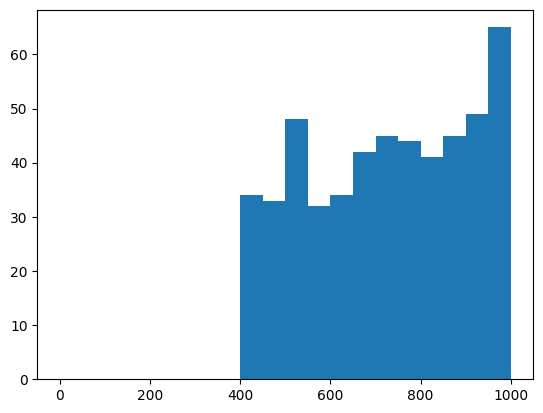

0  Interviews were removed
0  Interviews were removed


IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
# now we will filter the data

# lets see how the length of the interview distribution looks like
# we will make a histogram
# we want to see the small values so we will focus on interviews that are shorter than 1000 characters
interview_data["interview_length"] = interview_data["interview"].apply(lambda x: len(x))
plt.hist(interview_data["interview_length"], bins=20, range=(0,1000))
plt.show()

# filter all the interviews that are shorter than 400 characters
n=len(interview_data)
interview_data = interview_data[interview_data["interview_length"] > 400]
interview_data = interview_data.reset_index(drop=True)
print(n-len(interview_data), " Interviews were removed")

# filter duplicated interviews
# duplicated interviews are interviews that have the same content
n=len(interview_data)
interview_data = interview_data.drop_duplicates(subset="interview")
print(n-len(interview_data), " Interviews were removed")

# filter specific problematic interviews
interview_data = interview_data.drop(interview_data[(interview_data["date"]=="1994-09-07") & (interview_data["name"]=="Hingis, Martina")].index[0])

In [26]:
# writing the data to a csv file
interview_data.to_csv('processed_interviews.csv', index=False)